In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf

from src.utils import eval_RtnFcst
from src.utils import deco_print
from src.utils import load_dataframe
from src.utils import sharpe
from src.utils import max_1_month_loss
from src.utils import max_drawdown
from src.utils import construct_decile_portfolios
from src.utils import plot_decile_portfolios
from src.utils import plotReturnDecile
from src.utils import calculateTurnover_with_dl
from src.data.data_layer import DataInRamInputLayer
from src.model.model_utils import calculateStatistics
from src.model.model_utils import getFactorWithLargeCap
from src.model.model_RtnFcst import FeedForwardModelWithNA_Return_Ensembled

##### Model Configurations

In [2]:
logdirs = ['model_char_shift/model_FFN/%d' %k for k in range(1,10)]
with open(os.path.join('model_char_shift/model_FFN/config.json'), 'r') as file:
    config = json.load(file)

##### Load Data

In [3]:
dl_train = DataInRamInputLayer(config['individual_feature_file'])
dl_valid = DataInRamInputLayer(config['individual_feature_file_valid'])
dl_test = DataInRamInputLayer(config['individual_feature_file_test'])

In [4]:
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_train.npz')
assert(tmp['variable'][19] == 'LME')
value = tmp['data'][:,:,19]

tmp_valid = np.load('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_valid.npz')
assert(tmp_valid['variable'][19] == 'LME')
value_valid = tmp_valid['data'][:,:,19]

tmp_test = np.load('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_test.npz')
assert(tmp_test['variable'][19] == 'LME')
value_test = tmp_test['data'][:,:,19]

In [5]:
### Large Cap Stocks
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/mask_LME.npz')
mask_train = tmp['train']
mask_valid = tmp['valid']
mask_test = tmp['test']

In [6]:
### Large Cap Stocks 0.001%
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/mask_LME_0001.npz')
mask_train_0001 = tmp['train']
mask_valid_0001 = tmp['valid']
mask_test_0001 = tmp['test']

In [7]:
### Risk-free rate
df_tmp = load_dataframe('datasets/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=2, nrows=659)
df_train = df_tmp.loc['196701':'198612']
df_valid = df_tmp.loc['198701':'199112']
df_test = df_tmp.loc['199201':'201612']
rf_train = df_train.loc[:,'RF'].values / 100
rf_valid = df_valid.loc[:,'RF'].values / 100
rf_test = df_test.loc[:,'RF'].values / 100

##### Load Model

In [8]:
tf.reset_default_graph()
global_step = tf.train.get_or_create_global_step()
model = FeedForwardModelWithNA_Return_Ensembled(logdirs, config, 'test', global_step=global_step)
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=sess_config)

##### Variable Importance

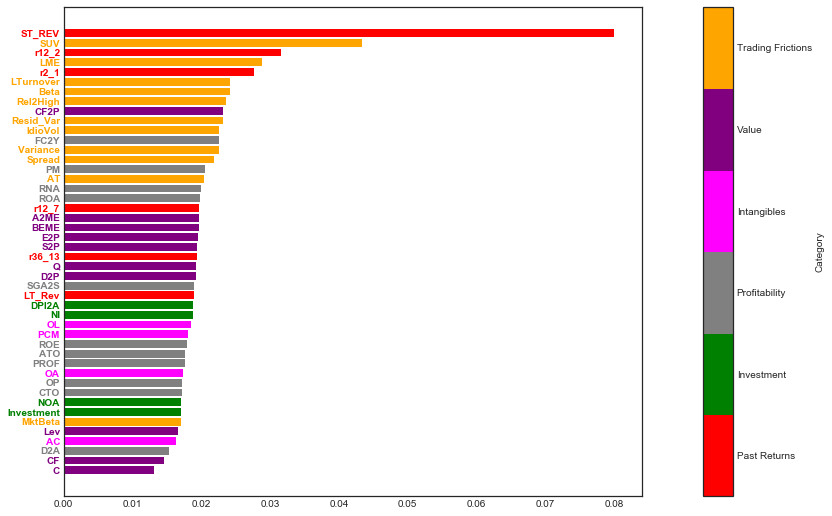

In [6]:
model.plotIndividualFeatureImportance(sess, dl_test, plotPath='model_char_shift/model_FFN/plot', top=46, figsize=(12, 9))

##### Model Performance

In [6]:
Ftrain = model.getSDFFactor(sess, dl_train, normalized=True, norm='l1')
Fvalid = model.getSDFFactor(sess, dl_valid, normalized=True, norm='l1')
Ftest = model.getSDFFactor(sess, dl_test, normalized=True, norm='l1')
# np.savez('model_char_shift/model_FFN/SDF_normalized.npz', train=Ftrain, valid=Fvalid, test=Ftest)

INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [7]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.45	Valid 0.42	Test 0.44
>==================> Max 1 Month Loss: Train -3.30	Valid -4.61	Test -3.37
>==================> Max Drawdown: Train 6	Valid 3	Test 5


In [9]:
Ftrain = model.getSDFFactor(sess, dl_train)
Fvalid = model.getSDFFactor(sess, dl_valid)
Ftest = model.getSDFFactor(sess, dl_test)
# np.savez('model_char_shift/model_FFN/SDF.npz', train=Ftrain, valid=Fvalid, test=Ftest)

INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [10]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.48	Valid 0.42	Test 0.47
>==================> Max 1 Month Loss: Train -4.60	Valid -4.72	Test -3.28
>==================> Max Drawdown: Train 6	Valid 3	Test 5


In [6]:
w_train = model.getPrediction(sess, dl_train)
w_valid = model.getPrediction(sess, dl_valid)
w_test = model.getPrediction(sess, dl_test)
# np.savez('model_char_shift/model_FFN/forecasts.npz', train=w_train, valid=w_valid, test=w_test)

INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [12]:
### Large Cap
Ftrain = getFactorWithLargeCap(w_train, dl_train, mask_train, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(w_valid, dl_valid, mask_valid, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(w_test, dl_test, mask_test, normalized=True, norm='l1')

In [13]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.32	Valid 0.17	Test 0.24
>==================> Max 1 Month Loss: Train -3.30	Valid -4.53	Test -5.08
>==================> Max Drawdown: Train 7	Valid 5	Test 5


In [7]:
### Large Cap 0.001%
Ftrain = getFactorWithLargeCap(w_train, dl_train, mask_train_0001, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(w_valid, dl_valid, mask_valid_0001, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(w_test, dl_test, mask_test_0001, normalized=True, norm='l1')

In [8]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.42	Valid 0.20	Test 0.30
>==================> Max 1 Month Loss: Train -3.89	Valid -4.66	Test -4.33
>==================> Max Drawdown: Train 6	Valid 4	Test 5


In [15]:
# EV, XS-R2
EV_train, XSR2_train, WXSR2_train = model.calculateStatistics(sess, dl_train)
EV_valid, XSR2_valid, WXSR2_valid = model.calculateStatistics(sess, dl_valid)
EV_test, XSR2_test, WXSR2_test = model.calculateStatistics(sess, dl_test)

INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [16]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.11	Valid 0.04	Test 0.04
>==================> XS-R2: Train -0.01	Valid 0.02	Test 0.03
>==================> (Weighted) XS-R2: Train 0.14	Valid -0.00	Test 0.15


In [10]:
### Large Cap
EV_train, XSR2_train, WXSR2_train = calculateStatistics(w_train, dl_train, mask_train)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(w_valid, dl_valid, mask_valid)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(w_test, dl_test, mask_test)

In [11]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.13	Valid 0.22	Test 0.09
>==================> XS-R2: Train -0.02	Valid 0.06	Test 0.03
>==================> (Weighted) XS-R2: Train 0.22	Valid 0.15	Test 0.26


In [9]:
### Large Cap 0.001%
EV_train, XSR2_train, WXSR2_train = calculateStatistics(w_train, dl_train, mask_train_0001)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(w_valid, dl_valid, mask_valid_0001)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(w_test, dl_test, mask_test_0001)

In [10]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.11	Valid 0.10	Test 0.05
>==================> XS-R2: Train 0.01	Valid 0.08	Test -0.02
>==================> (Weighted) XS-R2: Train 0.19	Valid 0.08	Test 0.18


In [8]:
### Turnover
w_train = model.getNormalizedWeightWithData(sess, dl_train)
w_valid = model.getNormalizedWeightWithData(sess, dl_valid)
w_test = model.getNormalizedWeightWithData(sess, dl_test)

_, _, T_train_plus_mean, T_train_minus_mean = calculateTurnover_with_dl(dl_train, w_train, rf_train)
_, _, T_valid_plus_mean, T_valid_minus_mean = calculateTurnover_with_dl(dl_valid, w_valid, rf_valid)
_, _, T_test_plus_mean, T_test_minus_mean = calculateTurnover_with_dl(dl_test, w_test, rf_test)

INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [9]:
deco_print('Turnover (Long): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_plus_mean, T_valid_plus_mean, T_test_plus_mean))
deco_print('Turnover (Short): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_minus_mean, T_valid_minus_mean, T_test_minus_mean))

>==================> Turnover (Long): Train 0.69	Valid 0.63	Test 0.65
>==================> Turnover (Short): Train 1.38	Valid 1.29	Test 1.27


##### Performance of Extreme Portfolio

In [9]:
deciles = [0.01, 0.05, 0.1, 0.25, 0.5]
SR = pd.DataFrame(np.zeros((len(deciles), 3)), index=deciles, columns=['train','valid','test'])
SR_value = pd.DataFrame(np.zeros((len(deciles), 3)), index=deciles, columns=['train','valid','test'])

In [10]:
for decile in deciles:
    SR.loc[decile, 'train'] = eval_RtnFcst(model, sess, dl_train, quantile=decile)[1]
    SR.loc[decile, 'valid'] = eval_RtnFcst(model, sess, dl_valid, quantile=decile)[1]
    SR.loc[decile, 'test'] = eval_RtnFcst(model, sess, dl_test, quantile=decile)[1]
for decile in deciles:
    SR_value.loc[decile, 'train'] = eval_RtnFcst(model, sess, dl_train, value=value, quantile=decile)[1]
    SR_value.loc[decile, 'valid'] = eval_RtnFcst(model, sess, dl_valid, value=value_valid, quantile=decile)[1]
    SR_value.loc[decile, 'test'] = eval_RtnFcst(model, sess, dl_test, value=value_test, quantile=decile)[1]

INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/9/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>===============

>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/9/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>===============

>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/9/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>===============

>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/9/model-best
>==================> Restored checkpoint


In [11]:
SR

,train,valid,test
0.01,1.241270,0.648566,0.655466
0.05,1.364297,1.098866,0.706342
0.10,1.295585,1.314723,0.672129
0.25,1.190140,1.199377,0.571438
0.50,1.090735,1.256454,0.521496


In [12]:
SR_value

,train,valid,test
0.01,0.977004,0.349197,0.385756
0.05,0.887942,0.712945,0.419876
0.10,0.700880,0.449859,0.318788
0.25,0.545985,0.284607,0.174412
0.50,0.427917,0.199222,0.149572


##### Predictive Performance

In [6]:
decile = 10
for _, (I_macro, I, R, mask) in enumerate(dl_train.iterateOneEpoch(subEpoch=False)):
    portfolios_train = construct_decile_portfolios(w_train, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    portfolios_valid = construct_decile_portfolios(w_valid, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    portfolios_test = construct_decile_portfolios(w_test, R, mask, decile=decile)
df = pd.DataFrame(np.concatenate([portfolios_train, portfolios_valid, portfolios_test]), columns=['decile %d' %(k+1) for k in range(decile)])

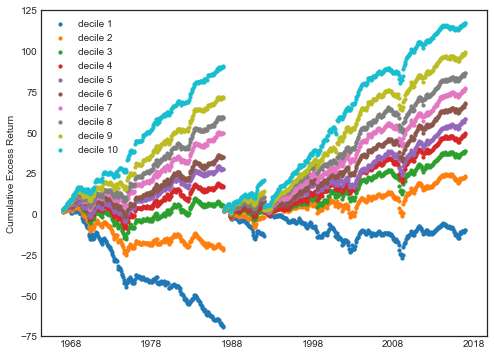

In [9]:
plot_decile_portfolios(df, plotPath='model_char_shift/model_FFN/plot')

>==================> Plotting Variable: r12_7	Elapse / Estimate: 1.54s / 1.54s


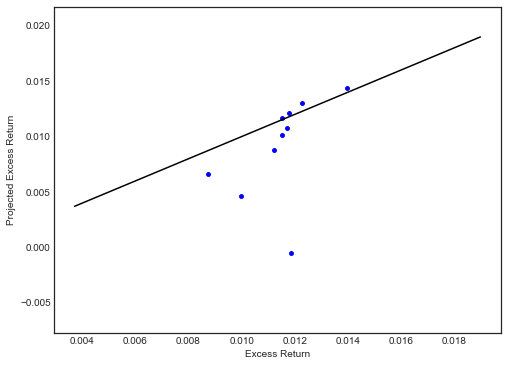

In [15]:
plotReturnDecile(dl_test, w_test, 'r12_7')

>==================> Plotting Variable: A2ME	Elapse / Estimate: 1.29s / 59.51s
>==================> Plotting Variable: AC	Elapse / Estimate: 2.67s / 61.39s
>==================> Plotting Variable: AT	Elapse / Estimate: 3.97s / 60.93s
>==================> Plotting Variable: ATO	Elapse / Estimate: 5.38s / 61.84s
>==================> Plotting Variable: BEME	Elapse / Estimate: 6.89s / 63.35s
>==================> Plotting Variable: Beta	Elapse / Estimate: 8.19s / 62.82s
>==================> Plotting Variable: C	Elapse / Estimate: 9.52s / 62.56s
>==================> Plotting Variable: CF	Elapse / Estimate: 10.84s / 62.33s
>==================> Plotting Variable: CF2P	Elapse / Estimate: 12.16s / 62.15s
>==================> Plotting Variable: CTO	Elapse / Estimate: 13.48s / 62.01s
>==================> Plotting Variable: D2A	Elapse / Estimate: 14.79s / 61.86s
>==================> Plotting Variable: D2P	Elapse / Estimate: 16.13s / 61.82s
>==================> Plotting Variable: DPI2A	Elapse / Estim

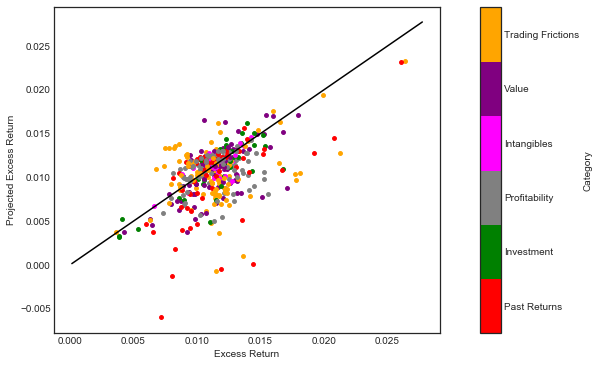

In [8]:
plotReturnDecile(dl_test, w_test, plotPath='model_char_shift/model_FFN/plot')

##### Plot Weight As Function of Firm Characteristics

INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

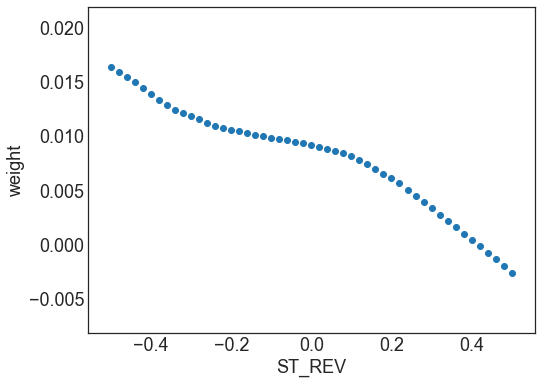

In [7]:
model.plotConditionalReturn1DWithChar(sess, dl_test, 'ST_REV', label='weight')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D 2.2D Contour 3.2D Contour Slice 4. 1D Curves: 4
Enter variable idx for x (0 - 45, 46 - 45): 32
Enter variable idx for y (0 - 45, 46 - 45): 43
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring para

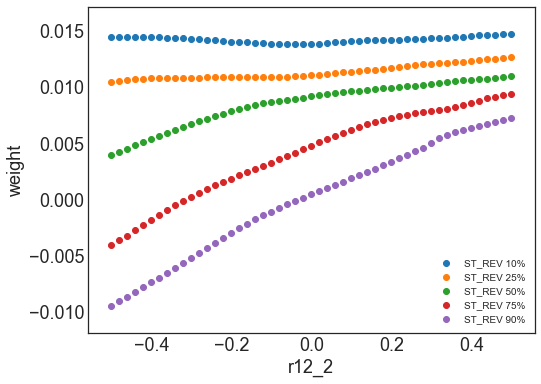

In [10]:
model.plotConditionalReturn(sess, dl_test, plotPath='model_char_shift/model_FFN/plot/2D', label='weight')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 5
Enter variable idx for x (0 - 45, 46 - 45): 43
Enter variable idx for y (0 - 45, 46 - 45): 18
Enter variable idx for z (0 - 45, 46 - 45): 4
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FF

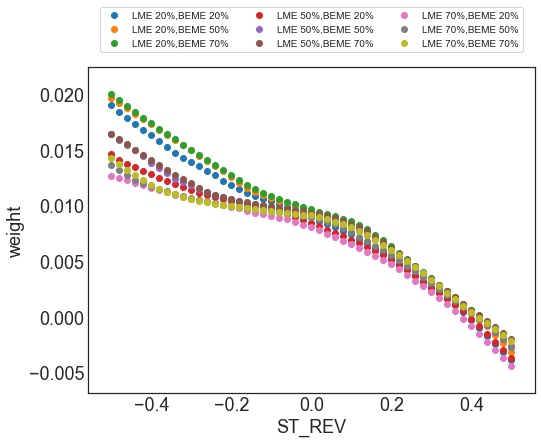

In [16]:
model.plotConditionalReturn(sess, dl_test, plotPath='model_char_shift/model_FFN/plot/3D', label='weight')

In [10]:
# model.plotConditionalReturn1DWithChar(sess, dl_test, 'All', plotPath='model_char_shift/model_FFN/plot/1D', label='weight')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D 2.2D Contour 3.2D Contour Slice: 2
Enter variable idx for x (0 - 45, 46 - 45): 18
Enter variable idx for y (0 - 45, 46 - 45): 4
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from mo

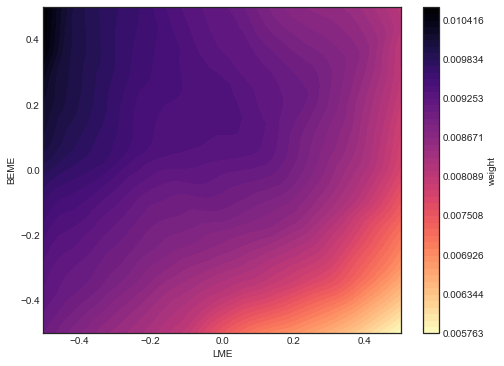

In [13]:
model.plotConditionalReturn(sess, dl_test, plotPath='model_char_shift/model_FFN/plot/2D', label='weight')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D 2.2D Contour 3.2D Contour Slice: 3
Enter variable idx for x (0 - 45, 46 - 45): 18
Enter variable idx for y (0 - 45, 46 - 45): 4
Enter variable idx for z (0 - 45, 46 - 45): 43
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/6/model-best
>==================> Restored checkpoi

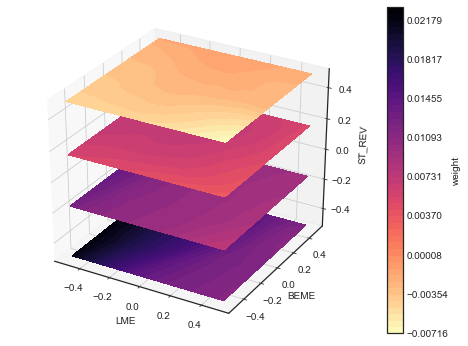

In [14]:
model.plotConditionalReturn(sess, dl_test, plotPath='model_char_shift/model_FFN/plot/3D', label='weight')

##### Plot Beta As Function of Firm Characteristics

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 3
Enter variable idx for x (0 - 45, 46 - 45): 18
Enter variable idx for y (0 - 45, 46 - 45): 4
Enter variable idx for z (0 - 45, 46 - 45): 43
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FFN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_FF

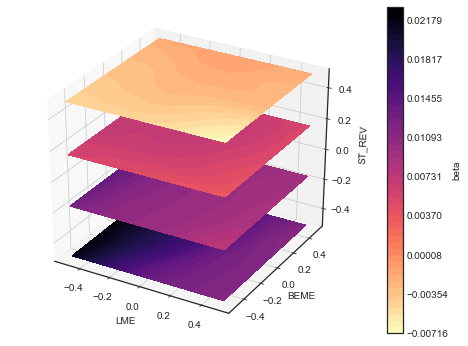

In [19]:
model.plotConditionalReturn(sess, dl_test, plotPath='model_char_shift/model_FFN/plot/beta', label='beta')